# Preparación

## Importamos librerias necesarias y definimos clases para sentencias y ejemplos

In [1]:
import argparse
import glob
import logging
import os
import random

import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorboardX import SummaryWriter
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from transformers import AdamW, WarmupLinearSchedule
from transformers import WEIGHTS_NAME, BertConfig, BertForTokenClassification, BertTokenizer
import pandas as pd

from io import open

import sys

import matplotlib.pyplot as plt

I1113 12:56:22.262555 140628687111936 file_utils.py:39] PyTorch version 1.2.0 available.
I1113 12:56:22.306426 140628687111936 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [2]:
MODEL_CLASSES = {
    "bert": (BertConfig, BertForTokenClassification, BertTokenizer),
}

class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["text"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:

device = "cuda"
n_gpu = 1

# Set seed
set_seed(42)



In [4]:
with torch.cuda.device(n_gpu):
    print(torch.cuda.current_device())

1


## Bajamos el modelo, config y tokenizer

In [5]:
with torch.cuda.device(n_gpu):
    # Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
    pad_token_label_id = CrossEntropyLoss().ignore_index

    model_type = "bert"
    config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

    bert_type = "bert-large-uncased"
    config = config_class.from_pretrained(bert_type,
                                              num_labels=2)
    tokenizer = tokenizer_class.from_pretrained(bert_type,
                                                    do_lower_case=True)
    model = model_class.from_pretrained(bert_type, from_tf=False,
                                            config=config)
    model.to(device)

    'done'

I1113 12:56:28.420320 140628687111936 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /home/dfurman/.cache/torch/transformers/6dfaed860471b03ab5b9acb6153bea82b6632fb9bbe514d3fff050fe1319ee6d.4c88e2dec8f8b017f319f6db2b157fee632c0860d9422e4851bd0d6999f9ce38
I1113 12:56:28.421726 140628687111936 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1113 12:56:29.0

# Entrenamos

## Funcion auxiliar para convertir a features

In [6]:
def convert_examples_to_features(examples,
                                 label_list,
                                 max_seq_length,
                                 tokenizer,
                                 cls_token_at_end=False,
                                 cls_token="[CLS]",
                                 cls_token_segment_id=1,
                                 sep_token="[SEP]",
                                 sep_token_extra=False,
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 pad_token_label_id=-1,
                                 sequence_a_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
#         if ex_index % 10000 == 0:
#             print("Writing example {} of {}".format(ex_index, len(examples)))
#             print("E.g: {}".format(example.words))

        tokens = []
        label_ids = []
        for word, label in zip(example.words, example.labels):
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, and padding ids for the remaining tokens
            label_ids.extend([label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))

        # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[:(max_seq_length - special_tokens_count)]
            label_ids = label_ids[:(max_seq_length - special_tokens_count)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens += [sep_token]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            # roberta uses an extra separator b/w pairs of sentences
            tokens += [sep_token]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
        else:
            input_ids += ([pad_token] * padding_length)
            input_mask += ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids += ([pad_token_segment_id] * padding_length)
            label_ids += ([pad_token_label_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=label_ids))
    return features

## Eval function

In [7]:
def evaluate(model, test_dataloader):
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    model.eval()
    device = "cuda"
    with torch.cuda.device(1):
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            with torch.no_grad():
                inputs = {"input_ids": batch[0],
                          "attention_mask": batch[1],
                          "token_type_ids": batch[2],
                          # XLM and RoBERTa don"t use segment_ids
                          "labels": batch[3]}
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]


                eval_loss += tmp_eval_loss.item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)
        eval_loss = eval_loss / nb_eval_steps
        preds = np.argmax(preds, axis=2)

        return eval_loss, preds, out_label_ids



## Train Function

In [8]:
def train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader):
    """ Train the model """
    
    train_batch_size = 4
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=train_batch_size)

    num_train_epochs = 2.0
    t_total = len(train_dataloader) // num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         "weight_decay": 0.1},
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=0, t_total=t_total)


    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    train_loss_timeline = []
    eval_loss_timeline = []
    f1_timeline = []
    model.zero_grad()
    train_iterator = trange(int(num_train_epochs), desc="Epoch", disable=True)
    set_seed(42)  # Added here for reproductibility (even between python 2 and 3)
    
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {"input_ids": batch[0],
                        "attention_mask": batch[1],
                        "token_type_ids": batch[2],
                        # XLM and RoBERTa don"t use segment_ids
                        "labels": batch[3]
            }
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            loss.backward()
            tr_loss += loss.item()
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad()
            
            global_step += 1

        # Evaluamos
        loss, _, _ = evaluate(model, dev_dataloader)
        eval_loss_timeline.append(loss)
        train_loss_timeline.append(tr_loss / global_step)
    tr_loss = 0
    global_step = 0
            

    return global_step, train_loss_timeline, eval_loss_timeline

## Train dataset

In [9]:
data = pd.read_csv("../train_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")

getter = SentenceGetter(data)
#Sacarle las oraciones que empiezan con "<", el autor, abstract, etc

sentences = [[s[0] for s in sent] for sent in getter.sentences]
labels = [[s[1] for s in sent] for sent in getter.sentences]

num_labels = len(labels)

examples = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences, labels))]
print(examples[22].words)
print(examples[22].labels)

['Motion', 'is', 'one', 'of', 'the', 'most', 'important', 'ingredients', 'of', 'CG', 'movies', 'and', 'computer', 'games', '.']
['claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'claim', 'O']


In [10]:
with torch.cuda.device(n_gpu):
    possible_labels = ["O", "claim"]
    features = convert_examples_to_features(examples, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )


        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)

    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    train_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

## Eval Dataset

In [11]:
devdata = pd.read_csv("../dev_mm.txt", sep='\t', encoding="latin1").fillna(method="ffill")

getter = SentenceGetter(devdata)

sentences_dev = [[s[0] for s in sent] for sent in getter.sentences]
labels_dev = [[s[1] for s in sent] for sent in getter.sentences]

num_labels = len(labels_dev)

examples_dev = [InputExample(guid, words, labels) for guid, (words, labels) in enumerate(zip(sentences_dev, labels_dev))]

len(examples_dev)

2554

In [12]:
with torch.cuda.device(1):
    device = "cuda"
    possible_labels = ["O", "claim"]
    features_dev = convert_examples_to_features(examples_dev, possible_labels, 50, tokenizer,
                                                    cls_token_at_end=False,
                                                    # xlnet has a cls token at the end
                                                    cls_token=tokenizer.cls_token,
                                                    cls_token_segment_id=0,
                                                    sep_token=tokenizer.sep_token,
                                                    sep_token_extra=False,
                                                    # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                                                    pad_on_left=False,
                                                    # pad on the left for xlnet
                                                    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                    pad_token_segment_id=0,
                                                    pad_token_label_id=pad_token_label_id
                                                    )

        # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features_dev], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features_dev], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features_dev], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_ids for f in features_dev], dtype=torch.long)
    
    all_input_ids.to(device)
    all_input_mask.to(device)
    all_segment_ids.to(device)
    all_label_ids.to(device)

    dev_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    dev_sampler = SequentialSampler(dev_dataset)
    dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=8)

In [13]:
# all_label_ids[22]
# loss, preds, truth = evaluate(model, dev_dataloader)

In [42]:
# truth_list = [(o,p) for sentence in zip(truth, preds) for (o,p) in zip(sentence[0], sentence[1]) if o != -100]

# t, p = [i for (i,j) in truth_list], [j for (i,j) in truth_list]

# f1score(t, p)

0.43056195301704286

# Corremos el entrenamiento

In [14]:
#train_dataset = load_and_cache_examples(tokenizer, labels, pad_token_label_id, mode="train")
with torch.cuda.device(n_gpu):
    global_step, train_loss_timeline, dev_loss_timeline = train(train_dataset, model, tokenizer, labels, pad_token_label_id, dev_dataloader)


Iteration: 100%|██████████| 4153/4153 [12:20<00:00,  5.78it/s]


NameError: name 'tr_loss' is not defined

In [18]:
dev_loss_timeline

[0.6023154196329414, 0.6023154196329414]

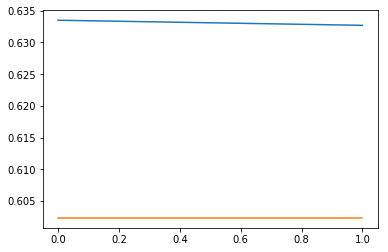

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(train_loss_timeline)), train_loss_timeline, label="train")
ax.plot(np.arange(len(dev_loss_timeline)), dev_loss_timeline, label="dev")

In [13]:
eval_sampler = SequentialSampler(eval_dataset)

In [22]:
from sklearn.metrics import classification_report

label_map = {i: label for i, label in enumerate(possible_labels)}

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score([o for sentence in out_label_list for o in sentence], [p for sentence in preds_list for p in sentence])
}

trues = [o for sentence in out_label_list for o in sentence]
predicteds = [p for sentence in preds_list for p in sentence]

print(classification_report(trues, predicteds))

              precision    recall  f1-score   support

     B-claim       0.00      0.00      0.00      1428
     I-claim       0.59      0.66      0.62     16140
           O       0.81      0.79      0.80     31331

   micro avg       0.72      0.72      0.72     48899
   macro avg       0.46      0.48      0.47     48899
weighted avg       0.71      0.72      0.72     48899



In [75]:
with torch.cuda.device(1):
    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=2)

    label_map = {i: label for i, label in enumerate(labels_test)}

    out_label_list = [[] for _ in range(out_label_ids.shape[0])]
    preds_list = [[] for _ in range(out_label_ids.shape[0])]

    for i in range(out_label_ids.shape[0]):
        for j in range(out_label_ids.shape[1]):
            if out_label_ids[i, j] != pad_token_label_id:
                out_label_list[i].append(label_map[out_label_ids[i][j]])
                preds_list[i].append(label_map[preds[i][j]])

    results = {
        "loss": eval_loss,
        "precision": precision_score(out_label_list, preds_list),
        "recall": recall_score(out_label_list, preds_list),
        "f1": f1_score(out_label_list, preds_list)
    }

KeyError: 15440

In [47]:
label_map[valid_tags[0]]


KeyError: tensor(-100, device='cuda:1')